# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [130]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [131]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Loaded {}".format(sheet_name))

Loaded M3Month


1. Select how many time series to train on (N series → 1 model)

In [132]:
# Select N series to train on
category_data = data[data['Category'].str.strip() == category]
N = 50  # Number of series to use for training

print(f"Training on {N} financial time series combined")
print(f"Total available: {len(category_data)} series\n")  

Training on 50 financial time series combined
Total available: 145 series



2. Process all N series and combine their training sequences

In [133]:
# Cell 6 - Modified to use global scaler

# Store all training sequences from N series
all_X_train = []
all_y_train = []
all_training_data = []  # Store all data before scaling

# First pass: collect all training data
for idx in range(N):
    series = category_data.iloc[idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[idx, 0]
    
    print(f"Processing series {idx+1}/{N}: {series_id} (length: {len(series)})")
    
    # Split and detrend
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    # Seasonal differencing
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    
    all_training_data.append(train_portion)

# Fit ONE global scaler on all training data combined
global_scaler = StandardScaler()
combined_training = np.concatenate(all_training_data)
global_scaler.fit(combined_training.reshape(-1, 1))

print(f"Global scaler fitted on {len(combined_training)} data points")
print(f"Mean: {global_scaler.mean_[0]:.4f}, Std: {global_scaler.scale_[0]:.4f}\n")

# Second pass: scale and create sequences
for idx in range(N):
    series = category_data.iloc[idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[idx, 0]
    
    # Repeat preprocessing (you could optimize this by storing results)
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    
    # Use GLOBAL scaler
    training_data = global_scaler.transform(train_portion.reshape(-1, 1)).flatten()
    
    # Create sequences
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i + lookback])
            y.append(data[i + lookback])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_sequences(training_data, lookback=12)
    
    all_X_train.append(X_train)
    all_y_train.append(y_train)
    
    print(f"  → Generated {len(X_train)} training sequences")

# Combine all sequences
X_train_combined = np.vstack(all_X_train)
y_train_combined = np.concatenate(all_y_train)

print(f"\n{'='*60}")
print(f"Combined training dataset:")
print(f"X_train shape: {X_train_combined.shape}")
print(f"y_train shape: {y_train_combined.shape}")
print(f"Total sequences: {len(X_train_combined)} (from {N} series)")
print(f"{'='*60}")

Processing series 1/50: N2522 (length: 143)
Processing series 2/50: N2523 (length: 144)
Processing series 3/50: N2524 (length: 144)
Processing series 4/50: N2525 (length: 144)
Processing series 5/50: N2526 (length: 144)
Processing series 6/50: N2527 (length: 144)
Processing series 7/50: N2528 (length: 134)
Processing series 8/50: N2529 (length: 134)
Processing series 9/50: N2530 (length: 134)
Processing series 10/50: N2531 (length: 134)
Processing series 11/50: N2532 (length: 134)
Processing series 12/50: N2533 (length: 134)
Processing series 13/50: N2534 (length: 134)
Processing series 14/50: N2535 (length: 134)
Processing series 15/50: N2536 (length: 134)
Processing series 16/50: N2537 (length: 134)
Processing series 17/50: N2538 (length: 134)
Processing series 18/50: N2539 (length: 134)
Processing series 19/50: N2540 (length: 134)
Processing series 20/50: N2541 (length: 134)
Processing series 21/50: N2542 (length: 122)
Processing series 22/50: N2543 (length: 134)
Processing series 2

5. Class for the multilayer perceptron

In [135]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, l2_lambda=0.0):
        
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  
        self.losses = []

    # In our implementation we chose the tanh activation function for the hidden layer
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation function
        self.hidden_input = X @ self.weight_hidden + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # No activation function for the output, since we are doing regression
        self.final_input = self.hidden_output @ self.weight_output + self.bias_output
        self.final_output = self.final_input  
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # sample size
        
        # reshape to match output shape
        y = y.reshape(-1, 1)
        
        output_error = output - y  
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # weights and bias update with L2 regularization
        self.weight_output -= self.learning_rate * (np.dot(self.hidden_output.T, output_error) / m + (self.l2_lambda / m) * self.weight_output)
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * (np.dot(X.T, hidden_error) / m + (self.l2_lambda / m) * self.weight_hidden)
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, patience=None, min_delta=1e-6):
   
        best_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in tqdm(range(epochs), desc="Training progress"):

            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # MSE
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            
            # L2 regularization for loss
            if self.l2_lambda > 0:
                l2_penalty = (self.l2_lambda / (2 * m)) * (np.sum(self.weight_hidden ** 2) + np.sum(self.weight_output ** 2))
                total_loss = loss + l2_penalty
                self.losses.append(total_loss)
            else:
                self.losses.append(loss)

            # Early stopping to avoid unnecessary training
            if patience is not None:
                if loss < best_loss - min_delta:
                    best_loss = loss
                    patience_counter = 0

                    # Save best weights
                    best_weights = {
                        'weight_hidden': self.weight_hidden.copy(),
                        'weight_output': self.weight_output.copy(),
                        'bias_hidden': self.bias_hidden.copy(),
                        'bias_output': self.bias_output.copy()
                    }
                else:
                    patience_counter += 1
                
                # Stop if patience exceeded
                if patience_counter >= patience:
                    tqdm.write(f"\nEarly stopping at epoch {epoch+1}")
                    tqdm.write(f"Best loss: {best_loss:.6f}")

                    # Restore best weights
                    if best_weights:
                        self.weight_hidden = best_weights['weight_hidden']
                        self.weight_output = best_weights['weight_output']
                        self.bias_hidden = best_weights['bias_hidden']
                        self.bias_output = best_weights['bias_output']
                    break
            
            # Progress updates
            if (epoch+1) % 4000 == 0:
                if patience is not None:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{patience}")
                else:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")
                    print(patience_counter)

        tqdm.write(f"Final loss: {loss:.10f}")
        
    def predict(self, X):
        output = self.forward(X)
        return output.flatten()
    


6. Train the shared MLP model on combined data

In [136]:
model = MLP(input_size=12, hidden_size=5, output_size=1, learning_rate=5e-4)
print(f"Training MLP on {len(X_train_combined)} sequences from {N} series...\n")
model.train(X_train_combined, y_train_combined, epochs=100000, patience=500, min_delta=1e-6)

Training MLP on 4632 sequences from 50 series...



Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Epoch 92000/100000, Loss: 0.510332, Best: 0.510333, Patience: 1/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Epoch 92000/100000, Loss: 0.510332, Best: 0.510333, Patience: 1/500


Training progress:  96%|█████████▋| 96371/100000 [00:50<00:01, 1966.02it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Epoch 92000/100000, Loss: 0.510332, Best: 0.510333, Patience: 1/500


Training progress:  96%|█████████▋| 96371/100000 [00:50<00:01, 1966.02it/s]

Epoch 96000/100000, Loss: 0.507852, Best: 0.507853, Patience: 1/500


Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Epoch 92000/100000, Loss: 0.510332, Best: 0.510333, Patience: 1/500


Training progress:  96%|█████████▋| 96371/100000 [00:50<00:01, 1966.02it/s]

Epoch 96000/100000, Loss: 0.507852, Best: 0.507853, Patience: 1/500


Training progress: 100%|██████████| 100000/100000 [00:52<00:00, 1915.00it/s]

Training MLP on 4632 sequences from 50 series...



Training progress:   4%|▍         | 4316/100000 [00:02<00:48, 1980.93it/s]

Epoch 4000/100000, Loss: 0.699569, Best: 0.699569, Patience: 0/500


Training progress:   8%|▊         | 8359/100000 [00:04<00:45, 1993.22it/s]

Epoch 8000/100000, Loss: 0.643326, Best: 0.643326, Patience: 0/500


Training progress:  12%|█▏        | 12402/100000 [00:06<00:43, 2033.70it/s]

Epoch 12000/100000, Loss: 0.621875, Best: 0.621875, Patience: 0/500


Training progress:  16%|█▌        | 16127/100000 [00:08<00:48, 1741.38it/s]

Epoch 16000/100000, Loss: 0.609430, Best: 0.609430, Patience: 0/500


Training progress:  20%|██        | 20299/100000 [00:10<00:48, 1627.76it/s]

Epoch 20000/100000, Loss: 0.600333, Best: 0.600333, Patience: 0/500


Training progress:  24%|██▍       | 24278/100000 [00:12<00:38, 1946.92it/s]

Epoch 24000/100000, Loss: 0.592820, Best: 0.592820, Patience: 0/500


Training progress:  28%|██▊       | 28247/100000 [00:14<00:36, 1985.21it/s]

Epoch 28000/100000, Loss: 0.586258, Best: 0.586258, Patience: 0/500


Training progress:  32%|███▏      | 32237/100000 [00:16<00:34, 1958.20it/s]

Epoch 32000/100000, Loss: 0.580290, Best: 0.580290, Patience: 0/500


Training progress:  36%|███▌      | 36232/100000 [00:18<00:32, 1970.26it/s]

Epoch 36000/100000, Loss: 0.574577, Best: 0.574577, Patience: 0/500


Training progress:  40%|████      | 40379/100000 [00:21<00:30, 1935.88it/s]

Epoch 40000/100000, Loss: 0.568890, Best: 0.568890, Patience: 0/500


Training progress:  44%|████▍     | 44335/100000 [00:23<00:28, 1932.63it/s]

Epoch 44000/100000, Loss: 0.563236, Best: 0.563236, Patience: 0/500


Training progress:  48%|████▊     | 48306/100000 [00:25<00:26, 1941.84it/s]

Epoch 48000/100000, Loss: 0.557896, Best: 0.557896, Patience: 0/500


Training progress:  52%|█████▏    | 52236/100000 [00:27<00:24, 1946.94it/s]

Epoch 52000/100000, Loss: 0.553008, Best: 0.553008, Patience: 0/500


Training progress:  56%|█████▌    | 56203/100000 [00:29<00:22, 1971.62it/s]

Epoch 56000/100000, Loss: 0.548313, Best: 0.548313, Patience: 0/500


Training progress:  60%|██████    | 60173/100000 [00:31<00:21, 1846.36it/s]

Epoch 60000/100000, Loss: 0.543307, Best: 0.543307, Patience: 0/500


Training progress:  64%|██████▍   | 64342/100000 [00:33<00:18, 1884.78it/s]

Epoch 64000/100000, Loss: 0.537697, Best: 0.537697, Patience: 0/500


Training progress:  68%|██████▊   | 68245/100000 [00:35<00:17, 1860.22it/s]

Epoch 68000/100000, Loss: 0.532492, Best: 0.532492, Patience: 0/500


Training progress:  72%|███████▏  | 72323/100000 [00:37<00:14, 1883.35it/s]

Epoch 72000/100000, Loss: 0.527931, Best: 0.527931, Patience: 0/500


Training progress:  76%|███████▋  | 76351/100000 [00:39<00:12, 1876.45it/s]

Epoch 76000/100000, Loss: 0.523751, Best: 0.523751, Patience: 0/500


Training progress:  80%|████████  | 80283/100000 [00:42<00:10, 1849.75it/s]

Epoch 80000/100000, Loss: 0.519884, Best: 0.519885, Patience: 1/500


Training progress:  84%|████████▍ | 84207/100000 [00:44<00:08, 1949.62it/s]

Epoch 84000/100000, Loss: 0.516343, Best: 0.516344, Patience: 1/500


Training progress:  88%|████████▊ | 88345/100000 [00:46<00:06, 1847.74it/s]

Epoch 88000/100000, Loss: 0.513156, Best: 0.513157, Patience: 1/500


Training progress:  92%|█████████▏| 92248/100000 [00:48<00:03, 1952.63it/s]

Epoch 92000/100000, Loss: 0.510332, Best: 0.510333, Patience: 1/500


Training progress:  96%|█████████▋| 96371/100000 [00:50<00:01, 1966.02it/s]

Epoch 96000/100000, Loss: 0.507852, Best: 0.507853, Patience: 1/500


Training progress: 100%|██████████| 100000/100000 [00:52<00:00, 1915.00it/s]

Epoch 100000/100000, Loss: 0.505669, Best: 0.505670, Patience: 1/500
Final loss: 0.5056693677


7. Test the model on a specific series (e.g., first series)

In [137]:
# Test on a specific series (e.g., series 0)
test_idx = 0
series = category_data.iloc[test_idx, 6:].dropna().astype(float)
series_id = category_data.iloc[test_idx, 0]

print(f"Testing model on series: {series_id}")

# Reproduce preprocessing for test series
y = series.values
train_size = len(y) - 18

poly = PolynomialFeatures(degree=2)
X_train_indices = np.arange(train_size).reshape(-1, 1)
X_all_indices = np.arange(len(y)).reshape(-1, 1)

x_poly_train = poly.fit_transform(X_train_indices)
poly_model = LinearRegression()
poly_model.fit(x_poly_train, y[:train_size])

x_poly_all = poly.transform(X_all_indices)
poly_trend = poly_model.predict(x_poly_all)
de_trended = y - poly_trend

months_in_year = 12
seasonal_diff = []
for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

seasonal_diff_array = np.array(seasonal_diff)
train_portion = seasonal_diff_array[:-18]
validation_portion = seasonal_diff_array[-18:]

scaler = StandardScaler()
scaler.fit(train_portion.reshape(-1, 1))
training_data = global_scaler.transform(train_portion.reshape(-1, 1)).flatten()
validation_data = global_scaler.transform(validation_portion.reshape(-1, 1)).flatten()


def forecast_multiple_steps(model, last_sequence, n_steps=18):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

last_sequence = training_data[-12:]
validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=18)

Testing model on series: N2522


8. Reversing to original scale and adding back trend and seasonality

In [138]:

# denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

# detrended values for the validation perdiod
reference_values = de_trended[-(36):-18]

# add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

# Gets trend values for the validation period 
validation_trend = poly_trend[-18:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend


9. Metrics of the prediction. Mean squared error and mean absolute percentage error.

In [139]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-18:]) ** 2)
original_mape = np.mean(np.abs((validation_predictions_original - y[-18:]) / y[-18:])) * 100
original_mae = np.mean(np.abs(validation_predictions_original - y[-18:]))

print(f"Mean squared error:  {original_mse:.2f}")
print(f"Mean absolute error: {original_mae:.2f}")
print(f"Mean absolute percentage error: {original_mape:.2f}%")


print("#"*60)

# Month by month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 19),
    'Actual': y[-18:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-18:],
    'Pct_Error': ((validation_predictions_original - y[-18:]) / y[-18:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

Mean squared error:  93815.44
Mean absolute error: 227.31
Mean absolute percentage error: 6.23%
############################################################

Month-by-Month Comparison:
 Month  Actual   Predicted       Error  Pct_Error
     1  3776.7 4402.592832  625.892832  16.572479
     2  3773.3 4521.433222  748.133222  19.827027
     3  3709.0 4224.331236  515.331236  13.894075
     4  3781.4 3727.971953  -53.428047  -1.412917
     5  3759.9 3489.897715 -270.002285  -7.181103
     6  3766.4 3469.874637 -296.525363  -7.872912
     7  3820.0 3443.860469 -376.139531  -9.846585
     8  3600.1 3540.102812  -59.997188  -1.666542
     9  3522.1 3615.392201   93.292201   2.648766
    10  3493.9 3553.701115   59.801115   1.711586
    11  3531.7 3674.162743  142.462743   4.033829
    12  3492.7 3617.818399  125.118399   3.582283
    13  3414.9 3579.972896  165.072896   4.833901
    14  3312.0 3534.376305  222.376305   6.714260
    15  3257.2 3328.303374   71.103374   2.182960
    16  3304.1 

11. Plot forecasts for all N training series

In [140]:
# Generate forecasts for all N training series
print(f"Generating forecasts for all {N} training series...\n")

results = []

for test_idx in range(N):
    series = category_data.iloc[test_idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[test_idx, 0]
    
    # Reproduce preprocessing for this series
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    validation_portion = seasonal_diff_array[-18:]
    
    scaler = StandardScaler()
    scaler.fit(train_portion.reshape(-1, 1))
    training_data = scaler.transform(train_portion.reshape(-1, 1)).flatten()
    validation_data = scaler.transform(validation_portion.reshape(-1, 1)).flatten()
    
    # Forecast
    last_sequence = training_data[-12:]
    validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=18)
    
    # Reverse transformations
    validation_predictions_denorm = scaler.inverse_transform(
        validation_predictions_scaled.reshape(-1, 1)
    ).flatten()
    
    reference_values = de_trended[-(36):-18]
    validation_predictions_deseasoned = validation_predictions_denorm + reference_values
    
    validation_trend = poly_trend[-18:]
    validation_predictions_original = validation_predictions_deseasoned + validation_trend
    
    # Calculate metrics
    actuals = y[-18:]
    mse = np.mean((validation_predictions_original - actuals) ** 2)
    mape = np.mean(np.abs((validation_predictions_original - actuals) / actuals)) * 100
    
    results.append({
        'series_id': series_id,
        'actuals': actuals,
        'predictions': validation_predictions_original,
        'mse': mse,
        'mape': mape
    })
    
    print(f"Series {test_idx+1}/{N}: {series_id} - MSE: {mse:.2f}, MAPE: {mape:.2f}%")

print("\nAll forecasts generated!")

# Calculate average metrics
avg_mse = np.mean([r['mse'] for r in results])
avg_mape = np.mean([r['mape'] for r in results])

print(f"\n{'='*60}")
print(f"Average MSE across {N} series:  {avg_mse:.2f}")
print(f"Average MAPE across {N} series: {avg_mape:.2f}%")
print(f"{'='*60}")

Generating forecasts for all 50 training series...

Series 1/50: N2522 - MSE: 97806.66, MAPE: 6.51%
Series 2/50: N2523 - MSE: 830641.47, MAPE: 16.36%
Series 3/50: N2524 - MSE: 494037.01, MAPE: 17.10%
Series 4/50: N2525 - MSE: 7308454.46, MAPE: 23.65%
Series 5/50: N2526 - MSE: 315469.17, MAPE: 9.90%
Series 6/50: N2527 - MSE: 1855710.16, MAPE: 17.47%
Series 7/50: N2528 - MSE: 244013.40, MAPE: 5.16%
Series 8/50: N2529 - MSE: 732764.04, MAPE: 12.03%
Series 9/50: N2530 - MSE: 664533.17, MAPE: 11.79%
Series 10/50: N2531 - MSE: 244012.86, MAPE: 5.16%
Series 11/50: N2532 - MSE: 2356793.01, MAPE: 27.22%
Series 12/50: N2533 - MSE: 12977699.99, MAPE: 51.24%
Series 13/50: N2534 - MSE: 3009505.68, MAPE: 26.35%
Series 14/50: N2535 - MSE: 2996074.35, MAPE: 26.88%
Series 15/50: N2536 - MSE: 798143.59, MAPE: 16.27%
Series 16/50: N2537 - MSE: 1451320.12, MAPE: 19.47%
Series 17/50: N2538 - MSE: 1020816.58, MAPE: 19.94%
Series 18/50: N2539 - MSE: 1832340.05, MAPE: 11.87%
Series 19/50: N2540 - MSE: 8380459

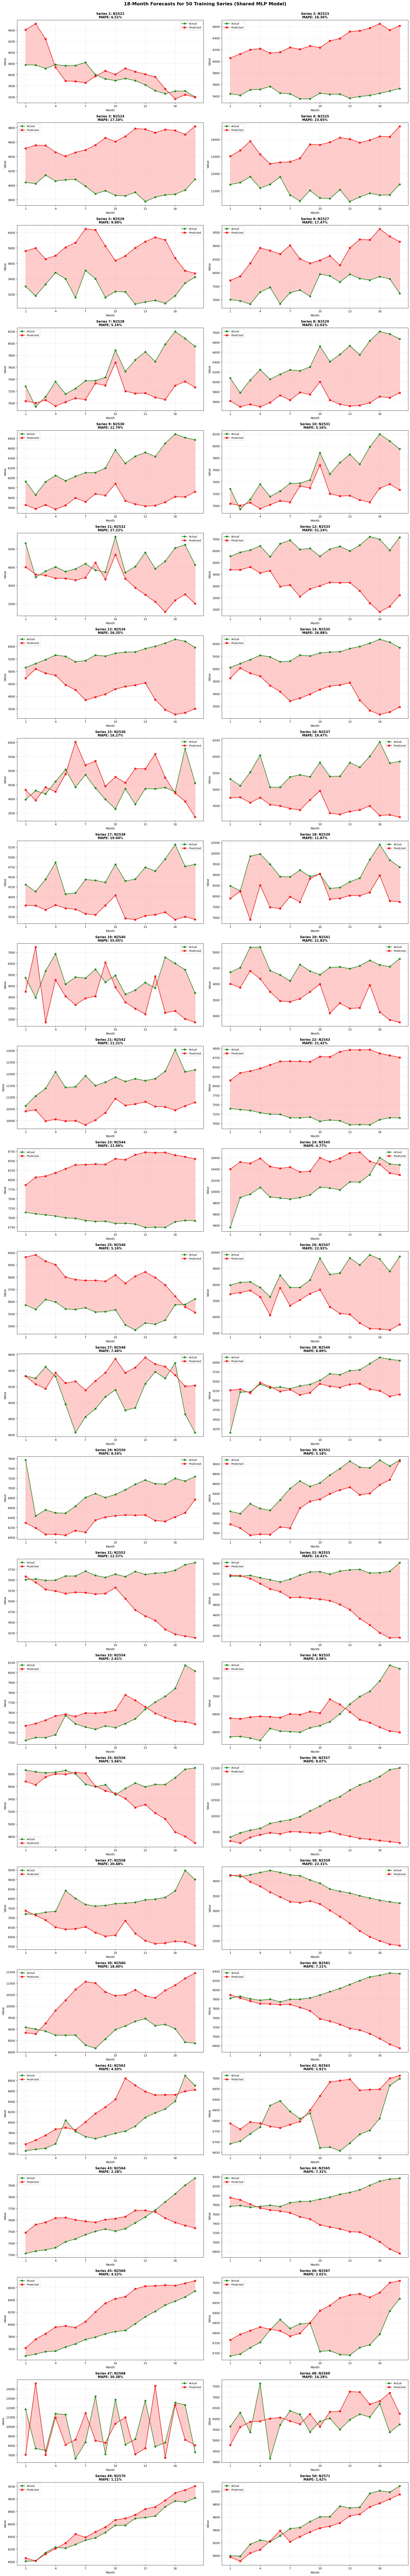

In [141]:
# Plot all N series in a grid
rows = (N + 1) // 2  # Calculate rows needed for 2 columns
fig, axes = plt.subplots(rows, 2, figsize=(20, 5 * rows))
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]
    
    actuals = result['actuals']
    predictions = result['predictions']
    
    months = np.arange(1, 19)
    ax.plot(months, actuals, 'go-', linewidth=2, markersize=6, 
            label='Actual', alpha=0.8)
    ax.plot(months, predictions, 'rs-', linewidth=2, markersize=6, 
            label='Predicted', alpha=0.8)
    ax.fill_between(months, actuals, predictions, 
                     alpha=0.2, color='red')
    
    ax.set_title(f"Series {idx+1}: {result['series_id']}\nMAPE: {result['mape']:.2f}%", 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(months[::3])

# Hide any unused subplots
for idx in range(N, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'18-Month Forecasts for {N} Training Series (Shared MLP Model)', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

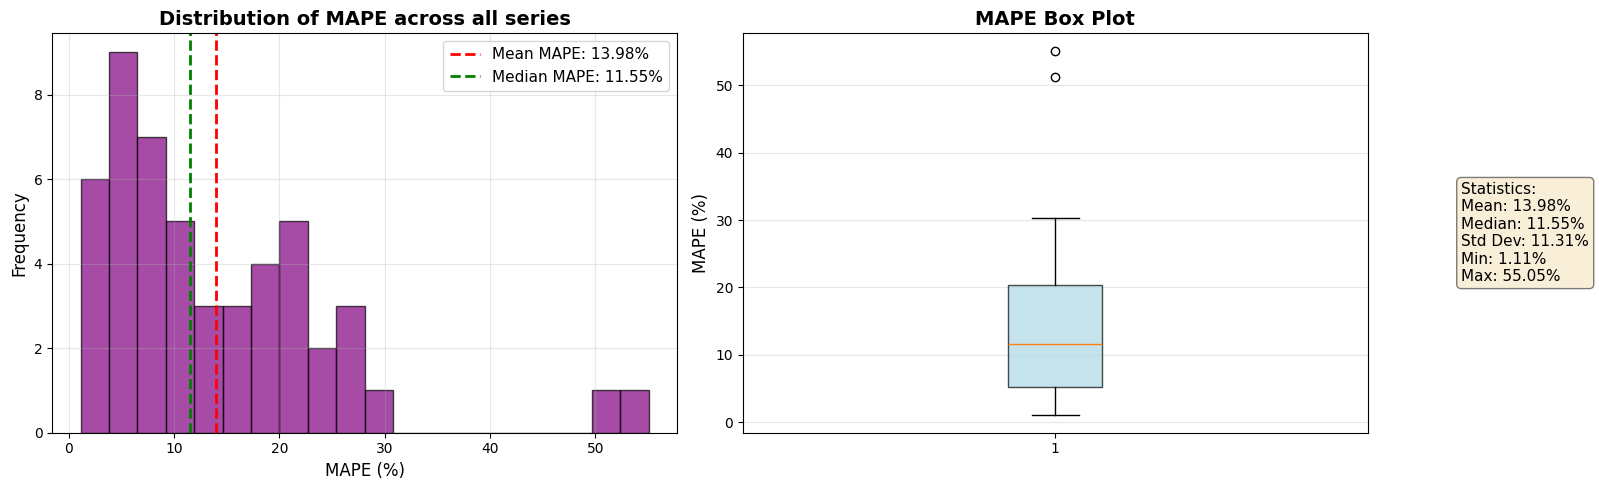


MAPE Error Distribution Analysis:
Mean MAPE:        13.98%
Median MAPE:      11.55%
Std Deviation:    11.31%
Min MAPE:         1.11%
Max MAPE:         55.05%
25th Percentile:  5.16%
75th Percentile:  20.35%

Top 5 Best Performing Series:
1. N2570: MAPE = 1.11%
2. N2571: MAPE = 1.42%
3. N2563: MAPE = 1.91%
4. N2567: MAPE = 2.01%
5. N2564: MAPE = 2.28%

Top 5 Worst Performing Series:
1. N2535: MAPE = 26.88%
2. N2532: MAPE = 27.22%
3. N2568: MAPE = 30.38%
4. N2533: MAPE = 51.24%
5. N2540: MAPE = 55.05%


In [142]:
# Add after Cell 11 (after calculating all results)

# Plot MAPE distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
ax1 = axes[0]
mape_values = [r['mape'] for r in results]
ax1.hist(mape_values, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax1.axvline(avg_mape, color='red', linestyle='--', linewidth=2, 
            label=f'Mean MAPE: {avg_mape:.2f}%')
ax1.axvline(np.median(mape_values), color='green', linestyle='--', linewidth=2,
            label=f'Median MAPE: {np.median(mape_values):.2f}%')
ax1.set_title('Distribution of MAPE across all series', fontsize=14, fontweight='bold')
ax1.set_xlabel('MAPE (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(mape_values, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
ax2.set_ylabel('MAPE (%)', fontsize=12)
ax2.set_title('MAPE Box Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"""Statistics:
Mean: {avg_mape:.2f}%
Median: {np.median(mape_values):.2f}%
Std Dev: {np.std(mape_values):.2f}%
Min: {np.min(mape_values):.2f}%
Max: {np.max(mape_values):.2f}%"""

ax2.text(1.15, 0.5, stats_text, transform=ax2.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print("MAPE Error Distribution Analysis:")
print(f"{'='*60}")
print(f"Mean MAPE:        {avg_mape:.2f}%")
print(f"Median MAPE:      {np.median(mape_values):.2f}%")
print(f"Std Deviation:    {np.std(mape_values):.2f}%")
print(f"Min MAPE:         {np.min(mape_values):.2f}%")
print(f"Max MAPE:         {np.max(mape_values):.2f}%")
print(f"25th Percentile:  {np.percentile(mape_values, 25):.2f}%")
print(f"75th Percentile:  {np.percentile(mape_values, 75):.2f}%")
print(f"{'='*60}")

# Show best and worst performing series
sorted_results = sorted(results, key=lambda x: x['mape'])
print("\nTop 5 Best Performing Series:")
for i, r in enumerate(sorted_results[:5], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")

print("\nTop 5 Worst Performing Series:")
for i, r in enumerate(sorted_results[-5:], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")

Filtered out 0 outliers above 100%


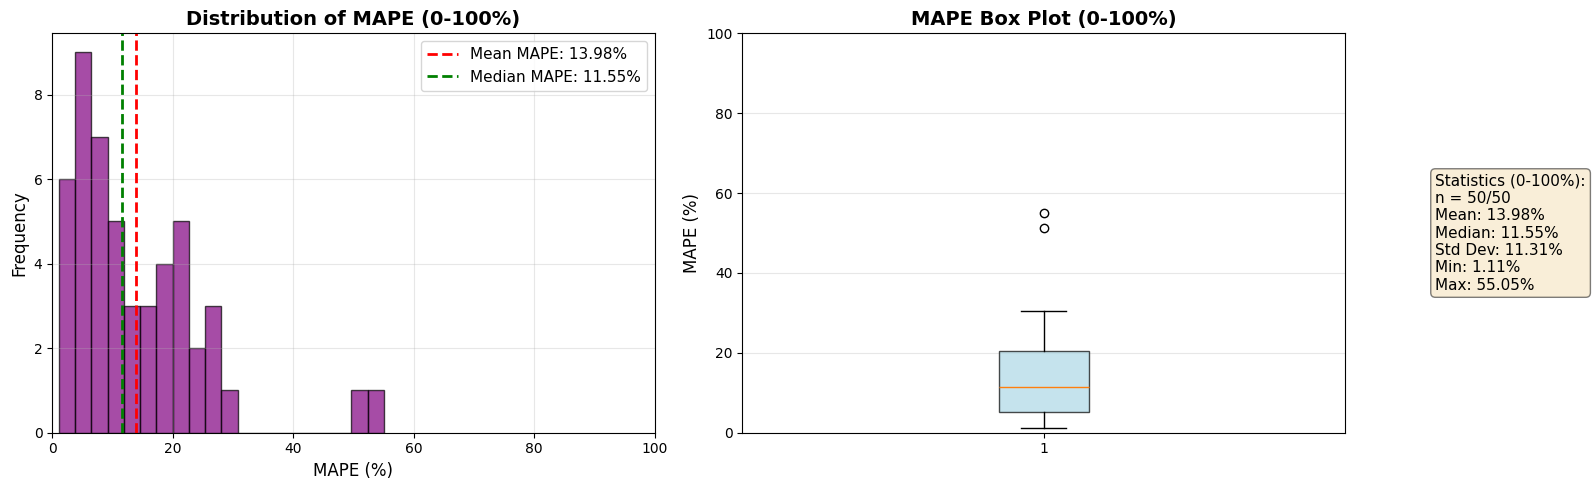


MAPE Error Distribution Analysis (0-100%):
Total series:     50
Filtered (0-100%): 50
Outliers (>100%):  0
Mean MAPE:        13.98%
Median MAPE:      11.55%
Std Deviation:    11.31%
Min MAPE:         1.11%
Max MAPE:         55.05%
25th Percentile:  5.16%
75th Percentile:  20.35%

Top 5 Best Performing Series (0-100% range):
1. N2570: MAPE = 1.11%
2. N2571: MAPE = 1.42%
3. N2563: MAPE = 1.91%
4. N2567: MAPE = 2.01%
5. N2564: MAPE = 2.28%

Top 5 Worst Performing Series (0-100% range):
1. N2535: MAPE = 26.88%
2. N2532: MAPE = 27.22%
3. N2568: MAPE = 30.38%
4. N2533: MAPE = 51.24%
5. N2540: MAPE = 55.05%


In [143]:
# Add after Cell 11 (after calculating all results)

# Plot MAPE distribution (filtered 0-100%)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Filter MAPE values to 0-100% range
mape_values = [r['mape'] for r in results]
mape_filtered = [m for m in mape_values if 0 <= m <= 100]
mape_outliers = [m for m in mape_values if m > 100]

print(f"Filtered out {len(mape_outliers)} outliers above 100%")
if mape_outliers:
    print(f"Outlier values: {mape_outliers}")

# Histogram
ax1 = axes[0]
ax1.hist(mape_filtered, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax1.axvline(np.mean(mape_filtered), color='red', linestyle='--', linewidth=2, 
            label=f'Mean MAPE: {np.mean(mape_filtered):.2f}%')
ax1.axvline(np.median(mape_filtered), color='green', linestyle='--', linewidth=2,
            label=f'Median MAPE: {np.median(mape_filtered):.2f}%')
ax1.set_title('Distribution of MAPE (0-100%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('MAPE (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xlim(0, 100)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(mape_filtered, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
ax2.set_ylabel('MAPE (%)', fontsize=12)
ax2.set_title('MAPE Box Plot (0-100%)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"""Statistics (0-100%):
n = {len(mape_filtered)}/{len(mape_values)}
Mean: {np.mean(mape_filtered):.2f}%
Median: {np.median(mape_filtered):.2f}%
Std Dev: {np.std(mape_filtered):.2f}%
Min: {np.min(mape_filtered):.2f}%
Max: {np.max(mape_filtered):.2f}%"""

ax2.text(1.15, 0.5, stats_text, transform=ax2.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print("MAPE Error Distribution Analysis (0-100%):")
print(f"{'='*60}")
print(f"Total series:     {len(mape_values)}")
print(f"Filtered (0-100%): {len(mape_filtered)}")
print(f"Outliers (>100%):  {len(mape_outliers)}")
print(f"Mean MAPE:        {np.mean(mape_filtered):.2f}%")
print(f"Median MAPE:      {np.median(mape_filtered):.2f}%")
print(f"Std Deviation:    {np.std(mape_filtered):.2f}%")
print(f"Min MAPE:         {np.min(mape_filtered):.2f}%")
print(f"Max MAPE:         {np.max(mape_filtered):.2f}%")
print(f"25th Percentile:  {np.percentile(mape_filtered, 25):.2f}%")
print(f"75th Percentile:  {np.percentile(mape_filtered, 75):.2f}%")
print(f"{'='*60}")

# Show best and worst performing series (from filtered list)
filtered_results = [r for r in results if 0 <= r['mape'] <= 100]
sorted_results = sorted(filtered_results, key=lambda x: x['mape'])

print("\nTop 5 Best Performing Series (0-100% range):")
for i, r in enumerate(sorted_results[:5], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")

print("\nTop 5 Worst Performing Series (0-100% range):")
for i, r in enumerate(sorted_results[-5:], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")

if mape_outliers:
    print(f"\nNote: {len(mape_outliers)} series excluded with MAPE > 100%")